## AA code Generation
---

In [1]:
import sys, os, json, copy, sklearn, shap
import pandas as pd
import numpy as np
import lightgbm as lgb
import pickle as pkl
from tqdm import tqdm
from smart_open import open
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import defaultdict as ddict

sys.path.insert(1, "../..")
from src.feature_selection import (
    get_top_k_features,
    get_monotone_dir,
    remove_corr_fts,
    get_feature_by_lgbm_importance,
    get_feature_shap_abs
)
from rdsutils.metrics import (
    get_binary_metrics,
    get_pred_reports
)

plt.style.use("seaborn")
%load_ext autoreload
%autoreload 2

In [2]:
local_artifact_path = "../../artifacts/final_model/"

In [3]:
segment = "prescreen_final"
seed = 42
artifact_path = "s3://sofi-data-science/jxu/pl-gen4/prescreen"
data_dir = "s3://sofi-data-science/jxu/pl-gen4/data_dump/pl-gen4-final-data/prescreen"
nr_to_consider = 100

# training data
target = "target"
target_indeterminate = "indeterminate"
ri_weight = "weight_ri"
weight = "weight"
weight_eval = "weight_eval"

In [4]:
with open(os.path.join(artifact_path, "config.json"), "rb") as f:
    config = json.load(f)

with open(os.path.join(artifact_path, segment, "mp_woe_imputer_state_dict.pkl"), "rb") as f:
    imputer_state_dict = pkl.load(f)
    
with open(os.path.join(artifact_path, segment, "monotone_dict.json"), "r") as f:
    monotone_dict = json.load(f)
    
with open(os.path.join(artifact_path, segment, "woe_dict.pkl"), "rb") as f:
    woe_dict = pkl.load(f)
    
with open(config["models"]["prescreen"]["lgbm_31_hp"], "rb") as f:
    model = pkl.load(f)
    
    

In [5]:
# columns to load
meta_cols = [
    target, target_indeterminate,
    ri_weight, weight_eval, weight, 'applicant_fico_score',
    'applicant_type', 'applicant_vantage_score', 'date_start',
    'gen3_score', 'id','period','ri_source', 'segmentation',
    'segmentation_description',
]
features = model.feature_name_.copy()
cols = meta_cols + features

# load data
df_unimp = pd.read_parquet(config["data"]["prescreen-final"]["df"], columns=cols)
test_df_unimp = pd.read_parquet(config["data"]["prescreen-final"]["test_df"], columns=cols)
df = pd.read_parquet(config["data"]["prescreen-final"]["df_imputed"], columns=cols)
test_df = pd.read_parquet(config["data"]["prescreen-final"]["test_df_imputed"], columns=cols)

### Data Statitics
---

In [6]:
df_unimp[[weight, "ri_source"]].groupby("ri_source")[weight].sum().round(2)

ri_source
booked    273651.50
others    444556.88
proxy     397572.00
Name: weight, dtype: float64

In [7]:
# 25%
df_ = df_unimp[[weight, "ri_source"]].groupby("ri_source")[weight].sum()
df_ /= df_.sum()
df_.loc[["booked", "proxy", "others"]]

ri_source
booked    0.245256
proxy     0.356317
others    0.398427
Name: weight, dtype: float64

#### Model
---

In [8]:
final_features = model.feature_name_.copy()
final_features

['p13_upl8132',
 'p13_bcc8322',
 'p13_bcc5520',
 't11_tall3205',
 'p13_upl0438',
 'p13_all7312',
 'p13_all7518',
 'p13_rta7300',
 'p13_iqz9420',
 'p13_iqf9540',
 'p13_iqt9510',
 'p13_iqz9425',
 't11_trev0722',
 't11_tstu2752',
 't11_tiln2755',
 't11_tmti2752',
 't11_tiln2754',
 'p13_all7936',
 'p13_all8352',
 'p13_cru1300',
 'p13_reh7120',
 't11_tbca2526',
 't11_tbca3530',
 't11_tbca4504',
 't11_tbca2381',
 't11_tbcc3305',
 't11_tbcc1303',
 'p13_upl8320',
 'p13_aut8140',
 'p13_cru8320',
 'p13_rtr5520']

In [9]:
from pprint import pprint
pprint(final_features, compact=True)

['p13_upl8132', 'p13_bcc8322', 'p13_bcc5520', 't11_tall3205', 'p13_upl0438',
 'p13_all7312', 'p13_all7518', 'p13_rta7300', 'p13_iqz9420', 'p13_iqf9540',
 'p13_iqt9510', 'p13_iqz9425', 't11_trev0722', 't11_tstu2752', 't11_tiln2755',
 't11_tmti2752', 't11_tiln2754', 'p13_all7936', 'p13_all8352', 'p13_cru1300',
 'p13_reh7120', 't11_tbca2526', 't11_tbca3530', 't11_tbca4504', 't11_tbca2381',
 't11_tbcc3305', 't11_tbcc1303', 'p13_upl8320', 'p13_aut8140', 'p13_cru8320',
 'p13_rtr5520']


In [10]:
final_params = model.get_params()
final_params

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.007,
 'max_depth': 8,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 2500,
 'n_jobs': -1,
 'num_leaves': 45,
 'objective': 'binary',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': 'auc',
 'verbosity': -1,
 'early_stopping_rounds': None,
 'feature_pre_filter': False,
 'lambda_l1': 3.9,
 'lambda_l2': 8.4,
 'feature_fraction': 0.9,
 'bagging_fraction': 0.9,
 'min_data_in_leaf': 700,
 'monotone_constraints': [-1,
  -1,
  -1,
  -1,
  1,
  -1,
  1,
  1,
  1,
  -1,
  -1,
  1,
  1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  1,
  -1,
  -1,
  -1,
  1,
  -1,
  1,
  -1,
  1,
  -1,
  -1],
 'seed': 42}

In [11]:
n_samples = 100000
sample_df = df.sample(n_samples, random_state=seed)

### PDP
---

Current Process
* Normalize the risk model scores to a common range of values from 0 to 100
* Subtract the normalized value from 100 to convert to a weakness score (the higher the weakness, e.g. distance from ideal, the more impactful the score is contributing to the decline
* Return the reasons based on the weakness scores.
* More details about the score combining is discussed in the documents:How to combine two or more score reasons



In [19]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import math


def partial_dependency_woe(model, df, feature,model_features,woe_dict=None, num_cut=20, sample_size=None):
    """
    Calculate partial dependency of a feature given a model.
    """
    if sample_size:
        d = df[model_features].sample(sample_size).copy()
    else:
        d = df[model_features].copy()
    
    
    ### check if woe_dict is available
    if woe_dict is None or 'cutoff' not in woe_dict[feature]:
        cutoff1=[0]
    else:
        # for boundary binning?
        cutoff1= woe_dict[feature]['cutoff']
    
    cutoff=cutoff1.copy()
            
    ### if woe cut is less than num_cut, then cut the values based on quantiles
    ### get the list of cutoff values for each attributes
    if len(cutoff1)<num_cut:
        quant_list=list(np.linspace(0.001,0.999,num_cut))
        cutoff=[df[feature].quantile(x) for x in quant_list]
        cutoff=list(set(cutoff))
        cutoff.insert(len(cutoff),float("inf"))
        cutoff.insert(0,float("-inf"))    
    
    if (len(cutoff1)>=len(cutoff)/4)&(len(cutoff1)>=20):
        cutoff=cutoff1
    
    cutoff.sort()
    
    lable=list(range(1,len(cutoff)))
    d['attr_label']=pd.cut(d[feature],cutoff,right=True,labels=lable)
    
    df_cut=pd.DataFrame()
    
    df_cut['min']=d[d[feature].isnull()==False].groupby('attr_label')[feature].min()
    df_cut['max']=d[d[feature].isnull()==False].groupby('attr_label')[feature].max()
    df_cut['grid']=d[d[feature].isnull()==False].groupby('attr_label')[feature].median()
    df_cut=df_cut.reset_index()
    df_cut=df_cut[df_cut['grid'].isnull()==False]
    
    
    df_cut.at[10000,'min']=np.nan
    df_cut.at[10000,'max']=np.nan
    df_cut.at[10000,'grid']=np.nan
    
    grid=df_cut['grid'].to_list()
    
    preds={}
    
    
    for x in grid:
        d[feature] = x
        y = np.average(model.predict(d[model_features]))
        if np.isnan(x):
            df_cut.loc[df_cut['grid'].isnull(),'pred']=y
        else:
            df_cut.loc[df_cut['grid']==x,'pred']=y 
         
    # produce a cutoff df?
    return df_cut



def pdp_dict(model, df, attr_list=None, woe_dict=None, num_cut=20,sample_size=None,print_ind=False, return_all=False):
    # the main function
    pdp_dict={}
   
    model_features=model.feature_name()
    
    # mean prediction
    # what is the model pred format?
    #     model/booster generates a 1d series of probabilities
    pred_mean=np.mean(model.predict(df[model_features]))
    
    #print("processing pdp:") 
    fig = plt.figure(figsize=(30, 160))
    i=0
    
    # get feature and feature importance, sort by importance
    attr_importance_df1=pd.DataFrame()
    attr_importance_df1['feature']=model.feature_name()
    attr_importance_df1['importance']=model.feature_importance(importance_type='gain',iteration=model.best_iteration)
    attr_importance_df1.sort_values(by="importance",ascending=False,inplace=True)
    
    if attr_list is None:
        attr_list=attr_importance_df1['feature'].to_list()
    
    # how does df_plot look like?
    for attr in  attr_list:
        
        df_11=partial_dependency_woe(model, df, attr, model_features, woe_dict,num_cut,sample_size=sample_size)
        nn=len(df_11)
        df_11['impact']=df_11['pred']-np.repeat(pred_mean,nn)
        pdp_dict[attr]=df_11
        i=i+1
        
        if print_ind==True:
            #if len(df_11)<num_cut:
            #    ax = fig.add_subplot(20, 3, i)
            #    x_list=list(range(len(pdp_dict[attr]['grid'])-1))
            #    ax.plot(x_list,pdp_dict[attr]['impact'][:-1],'C2')
            #    ax.set_xticks(x_list)
            #    ax.set_xticklabels(np.round(pdp_dict[attr]['grid'][:-1],3),rotation=45,fontsize=10)
                #ax.set_xticklabels(rotation=45)
            #    #ax.xaxis.set_major_locator(ticker.FixedLocator([list(pdp_dict['g201a']['grid'][0:3])+list(pdp_dict['g201a']['grid'][-3:])]))
            #    ax.title.set_text(attr) 
            #    ax.scatter(0 ,pdp_dict[attr]['impact'][-1],  color = 'red', marker= 'o')
            
            df_plot=df_11[df_11['grid'].isnull()==False]
            df_plot['attr_num']=pd.to_numeric(df_plot['attr_label'])
            ax = fig.add_subplot(20, 3, i)
            ax.plot(df_plot['attr_num'].values, df_plot['impact'].values,'C2')
            ax.axhline(y=0,linestyle='--', color='g')
            ax.get_xaxis().set_ticks([])
            x_min=df_11['min'].min()
            x_max=df_11['max'].max()
            xlable='min:{0}                                                              max:{1}'.format(x_min,x_max)
            ax.set_xlabel(xlable)
            ax.set_ylabel('impact')
            ax.title.set_text(attr)
            # missing value loc
            ax.scatter(1 ,df_11['impact'][10000],  color = 'red', marker= 'X',s=40)
         
    # attr_importance_df1
    # df_plot
    if return_all:
        return pdp_dict, attr_importance_df1, df_plot
    return pdp_dict
        

    
def partial_dependency_ice(model, df, feature,woe_dict=None, num_cut=20,sample_size=None):
    """
    Calculate partial dependency of a feature given a model.
    """
    
    model_features=model.feature_name()
    
    if sample_size:
        d = df[model_features].sample(sample_size).copy()
    else:
        d = df[model_features].copy()
    
    
    ### check if woe_dict is available
    if woe_dict is None:
        cutoff1=[0]
    else:
        cutoff1= woe_dict[feature]['cutoff']
    
    cutoff=cutoff1.copy()
            
    ### if woe cut is less than num_cut, then cut the values based on quantiles
    ### get the list of cutoff values for each attributes
    if len(cutoff1)<num_cut:
        quant_list=list(np.linspace(0.001,0.999,num_cut))
        cutoff=[df[feature].quantile(x) for x in quant_list]
        cutoff=list(set(cutoff))
        cutoff.insert(len(cutoff),float("inf"))
        cutoff.insert(0,float("-inf"))    
    
    if len(cutoff1)>=len(cutoff):
        cutoff=cutoff1
    
    cutoff.sort()
    
    lable=list(range(1,len(cutoff)))
    d['attr_label']=pd.cut(d[feature],cutoff,right=True,labels=lable)
    
    df_cut=pd.DataFrame()
    
    df_cut['min']=d[d[feature].isnull()==False].groupby('attr_label')[feature].min()
    df_cut['max']=d[d[feature].isnull()==False].groupby('attr_label')[feature].max()
    df_cut['grid']=d[d[feature].isnull()==False].groupby('attr_label')[feature].median()
    df_cut=df_cut.reset_index()
    df_cut=df_cut[df_cut['grid'].isnull()==False]
    
    df_cut.at[10000,'min']=np.nan
    df_cut.at[10000,'max']=np.nan
    df_cut.at[10000,'grid']=np.nan
    
    grid=df_cut['grid'].to_list()
      
    for x in grid:
        d[feature] = x
        d['model']=model.predict(d[model_features])
        y = d['model'].mean()
                                 
        if np.isnan(x):
            df_cut.loc[df_cut['grid'].isnull(),'pred']=y
        else:
            df_cut.loc[df_cut['grid']==x,'pred']=y 
                                 
        pred_quantile={}
        
        quant_list=[]
        for quant in [0.1,0.25,0.5,0.75,0.9]:
            i='p_'+str(int(quant*100))
            quant_list.append(i)
            pred_quantile[i]=d['model'].quantile(quant)                              
            if np.isnan(x):
                df_cut.loc[df_cut['grid'].isnull(),i]=pred_quantile[i]
            else:
                df_cut.loc[df_cut['grid']==x,i]=pred_quantile[i] 
    return df_cut,quant_list


def pdp_ice_plot(model, df, attr_list=None, woe_dict=None, num_cut=20,sample_size=None,print_ind=True,out_path='ice_pdp.pdf'):
    pdp_dict={}
    
    model_features=model.feature_name()
    
    pred_mean=np.mean(model.predict(df[model_features]))
    
    #print("processing pdp:") 
    fig = plt.figure(figsize=(30, 240))
    i=0
    
    attr_importance_df1=pd.DataFrame()
    attr_importance_df1['feature']=model.feature_name()
    attr_importance_df1['importance']=model.feature_importance(importance_type='gain',iteration=model.best_iteration)
    attr_importance_df1.sort_values(by="importance",ascending=False,inplace=True)
    
    if attr_list is None:
        attr_list=attr_importance_df1['feature'].to_list()
    
    
    for attr in  attr_list:
        
        df_11,q_list=partial_dependency_ice(model, df, attr, woe_dict,num_cut,sample_size)
        
        nn=len(df_11)
        df_11['impact']=df_11['pred']-np.repeat(pred_mean,nn)
        for aa in q_list:
            df_11[aa]=df_11[aa]-np.repeat(pred_mean,nn)
        
        i=i+1
        
        if print_ind==True:
            
            df_plot=df_11[df_11['grid'].isnull()==False]
            df_plot['attr_num']=pd.to_numeric(df_plot['attr_label'])
            ax = fig.add_subplot(18, 2, i)
            
            ax.plot(df_plot['attr_num'].values, df_plot['impact'].values,'C2',linewidth=4)
            
            for aa in q_list:
                ax.plot(df_plot['attr_num'].values ,df_plot[aa].values, linestyle='dotted',linewidth=3)
            
            ax.axhline(y=0,linestyle='--', color='g')
            ax.get_xaxis().set_ticks([])
            x_min=df_11['min'].min()
            x_max=df_11['max'].max()
            xlable='min:{0}                                                              max:{1}'.format(x_min,x_max)
            ax.set_xlabel(xlable,size=20)
            ax.set_ylabel('impact',size=20)
            ax.set_title(attr,fontsize=20)
            ax.tick_params(labelsize=20)
            
            ax.scatter(1 ,df_11['impact'][10000],  color = 'red', marker= 'X',s=80)
            
    return fig, ax  # plt.savefig(out_path)
        
    
    

#### Refactoring the AACode Class
---

What attributes do AACode class have?

* abstract class - logic
* visualization - if provided
* inference

Essentially this class should only have a transform action, as fitting are very technique dependent. For example, monotonicity + WOE requires the specific model type, and all we need at inference time is the model object along with the data points.

* Args:
    * Train
        * model - booster, since this is the most atomic structure for LGBM. Actually maybe should require it having a predict module or define a specific wrapper class for the model.
        * data, woe dictionary (?), arguments
            * eventually the eventual valid values of the dataset
            * special focus on missing values and special encodings
    * Inference
        * model
        * data points
        
* returns:
    * data frame containing top negatively impact features

CPU times: user 14h 10min 23s, sys: 29.9 s, total: 14h 10min 53s
Wall time: 9min 47s


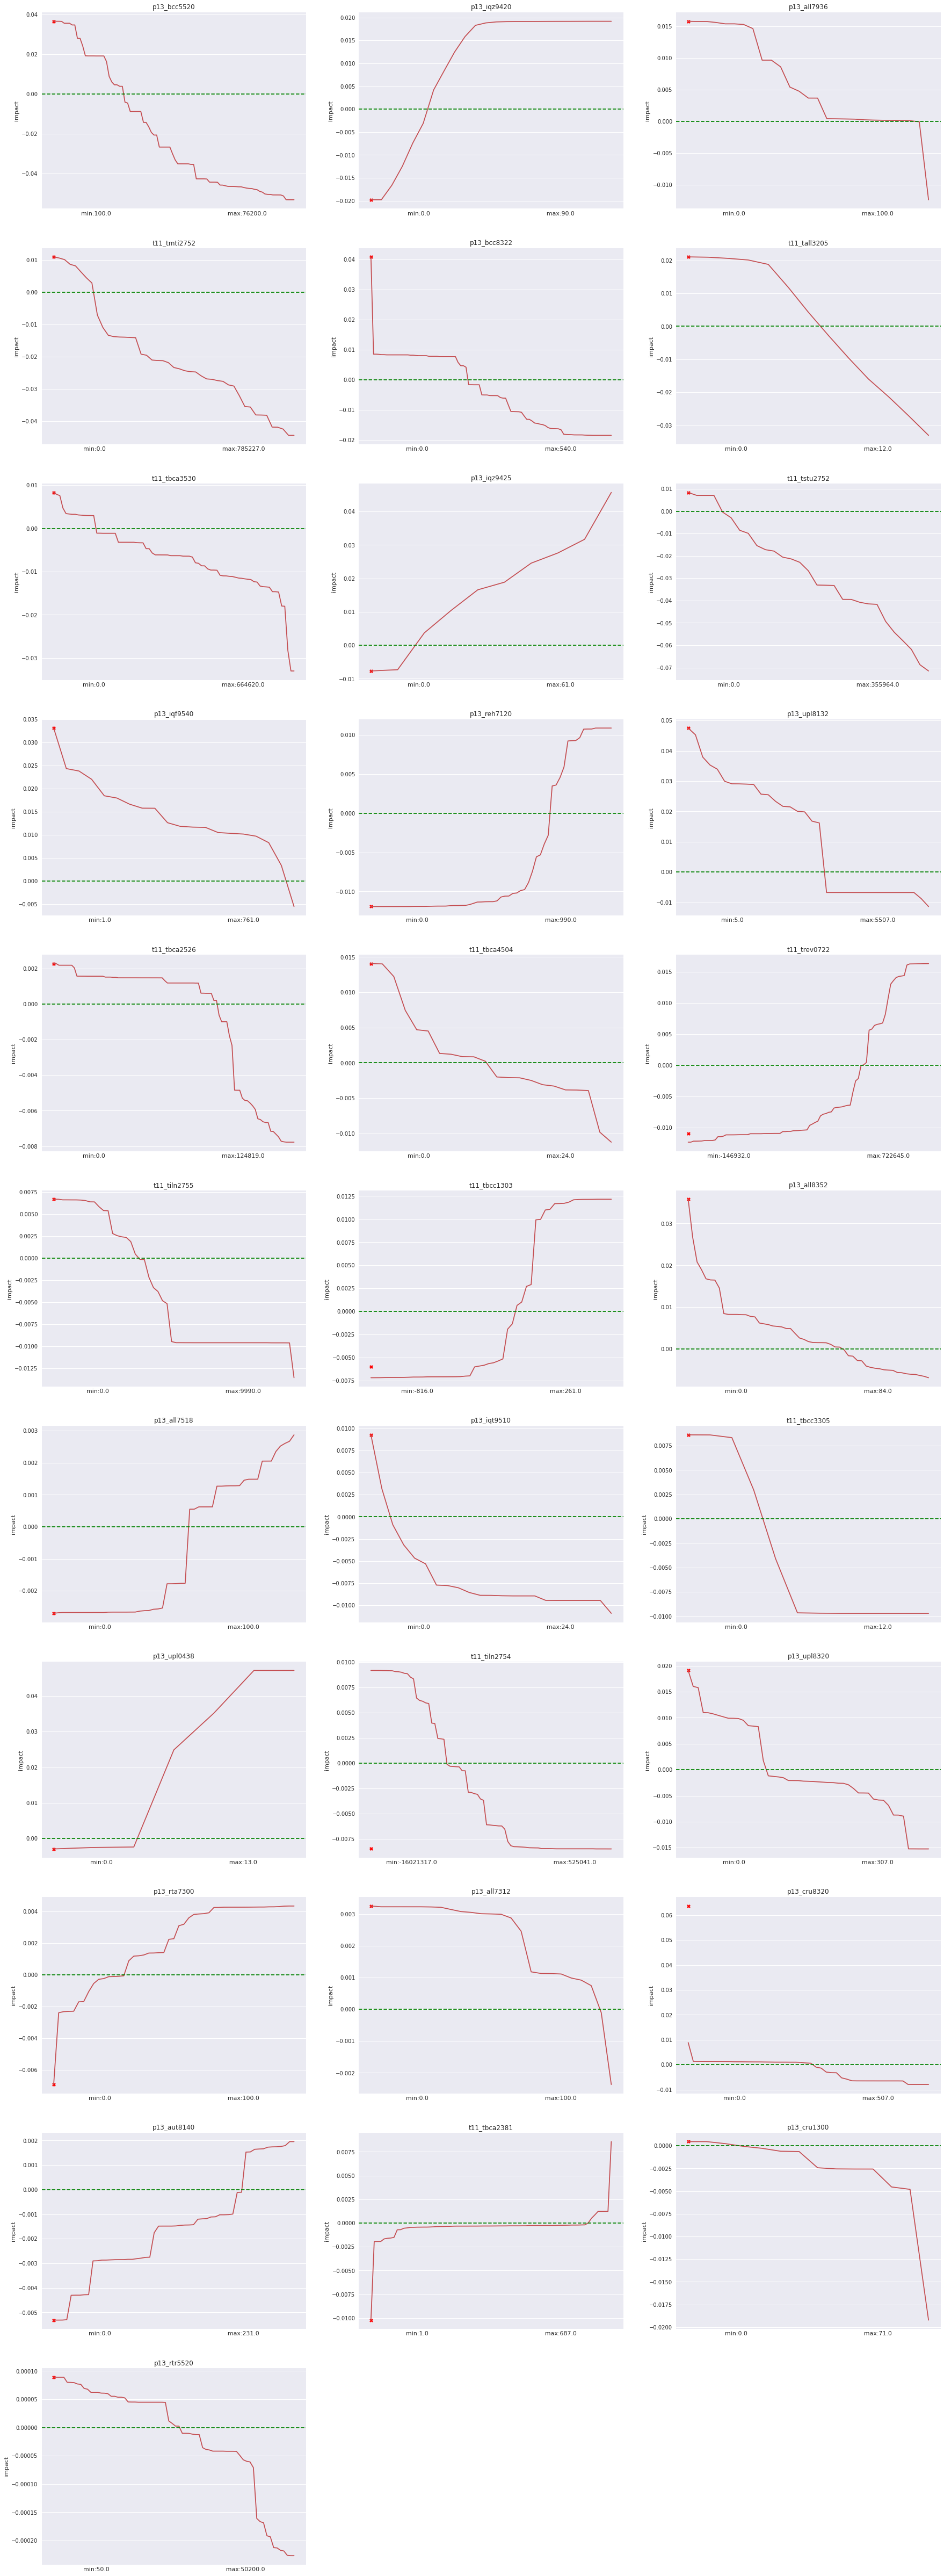

In [24]:
%%time
pdp_dict, attr_importance_df1, df_plot = pdp_dict(model.booster_, sample_df, woe_dict=woe_dict, 
                   num_cut=100, sample_size=None, print_ind=True, return_all=True)

In [23]:
pdp_obj["p13_bcc5520"]

,attr_label,min,max,grid,pred,impact
0,1,100.0,200.0,200.0,0.207577,0.036459
1,2,201.0,203.5,203.5,0.207577,0.036459
2,3,205.0,300.0,300.0,0.207577,0.036459
3,4,301.0,400.0,400.0,0.207520,0.036402
4,5,401.0,500.0,500.0,0.206594,0.035476
...,...,...,...,...,...,...
88,89,20016.0,21800.0,20900.0,0.118000,-0.053118
89,90,21810.0,25000.0,23300.0,0.117972,-0.053146
90,91,25007.0,39200.0,28473.5,0.117971,-0.053147
91,92,39333.0,76200.0,43300.5,0.117971,-0.053147


In [28]:
attr_importance_df1.shape

(31, 2)

In [26]:
attr_importance_df1.head()

,feature,importance
2,p13_bcc5520,2.843623e+06
8,p13_iqz9420,5.283075e+05
17,p13_all7936,4.987357e+05
15,t11_tmti2752,4.200270e+05
1,p13_bcc8322,4.146030e+05


In [29]:
df_plot.shape  # why there are 72 of them?

(72, 7)

In [27]:
df_plot.head()

,attr_label,min,max,grid,pred,impact,attr_num
0,1,50.0,100.0,100.0,0.171207,0.000089,1
1,2,105.0,275.0,250.0,0.171207,0.000089,2
2,3,278.0,300.0,300.0,0.171207,0.000089,3
3,4,302.0,405.0,400.0,0.171207,0.000089,4
4,5,406.0,500.0,500.0,0.171198,0.000080,5


In [30]:
df_plot.tail()

,attr_label,min,max,grid,pred,impact,attr_num
67,68,7117.0,7717.0,7500.0,0.170901,-0.000217,68
68,69,7720.0,8600.0,8000.0,0.170900,-0.000218,69
69,70,8602.0,10000.0,9450.0,0.170892,-0.000226,70
70,71,10001.0,20000.0,12000.0,0.170891,-0.000227,71
71,72,20010.0,50200.0,25000.0,0.170891,-0.000227,72


In [31]:
df_plot

,attr_label,min,max,grid,pred,impact,attr_num
0,1,50.0,100.0,100.0,0.171207,0.000089,1
1,2,105.0,275.0,250.0,0.171207,0.000089,2
2,3,278.0,300.0,300.0,0.171207,0.000089,3
3,4,302.0,405.0,400.0,0.171207,0.000089,4
4,5,406.0,500.0,500.0,0.171198,0.000080,5
...,...,...,...,...,...,...,...
67,68,7117.0,7717.0,7500.0,0.170901,-0.000217,68
68,69,7720.0,8600.0,8000.0,0.170900,-0.000218,69
69,70,8602.0,10000.0,9450.0,0.170892,-0.000226,70
70,71,10001.0,20000.0,12000.0,0.170891,-0.000227,71


CPU times: user 13h 29min 42s, sys: 22 s, total: 13h 30min 4s
Wall time: 9min 47s


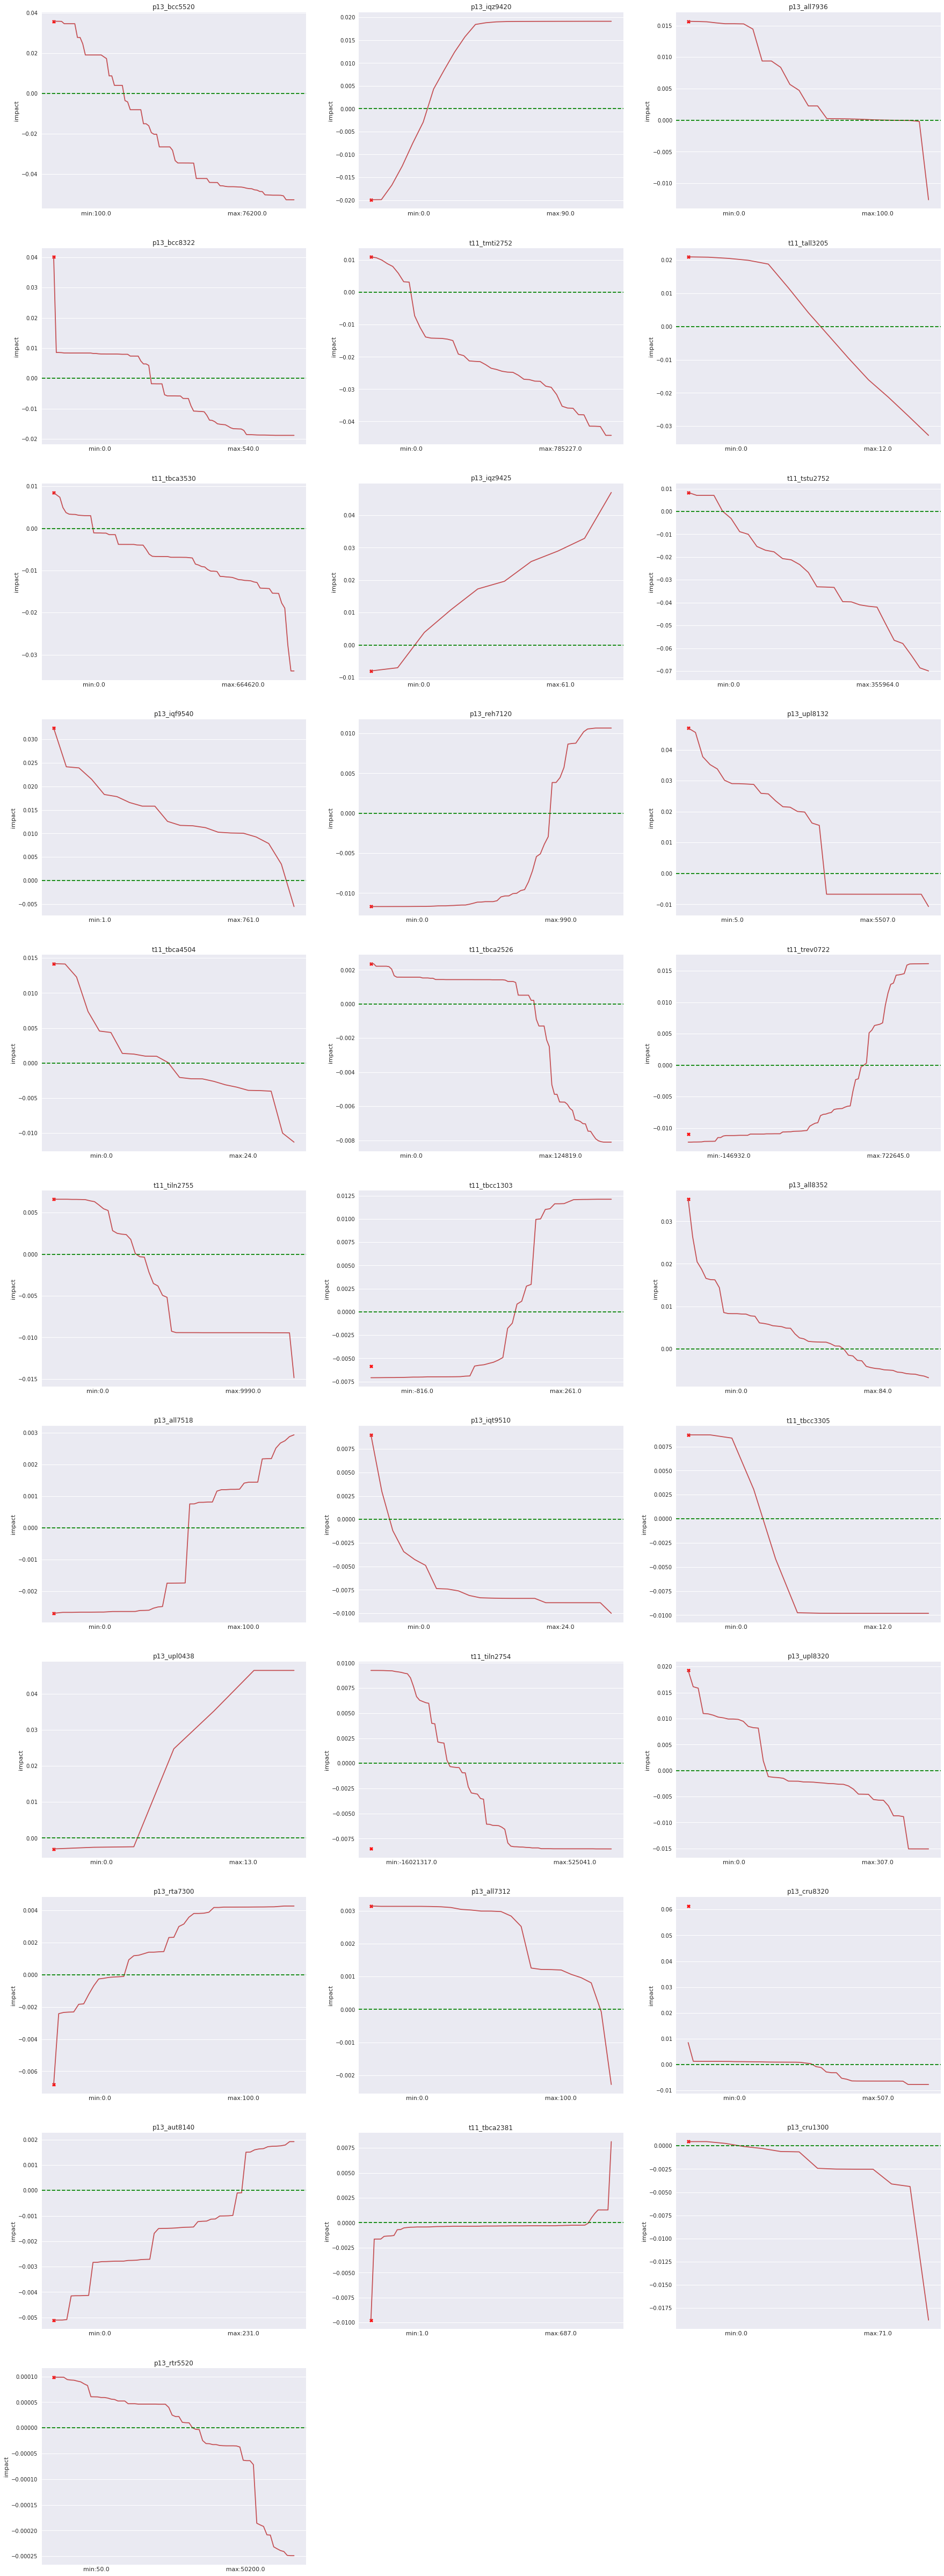

In [18]:
%%time
pdp_obj = pdp_dict(model.booster_, sample_df, woe_dict=woe_dict, 
                   num_cut=100, sample_size=None, print_ind=True)

In [22]:
aa_dir = os.path.join(local_artifact_path, "aa_code")
os.makedirs(aa_dir, exist_ok=True)

with open(os.path.join(aa_dir, "pdp.pkl"), "wb") as f:
    pkl.dump(pdp_obj, f)

In [85]:
import pandas as pd
import numpy as np


def adverse_action_code(input_df,pdp,model,aa_df):
           
    inq_list=['IQT9420']
    
    i=0
    feature_list=model.feature_name()
    impact_df=pd.DataFrame()
    grid={}
    
    for attr in feature_list:
        if input_df[attr].isna().sum()>=1:
            pos=10000
        else:
            a=np.array(input_df[attr].values)-np.array(pdp[attr][0:-1]['min'].to_list())
            b=np.ma.MaskedArray(a,a<0, fill_value=np.inf)
            pos=np.ma.argmin(b)
     
            
        impact_df.loc[i,'attr']=attr
        impact_df.loc[i,'pos']=pos
        impact_df.loc[i,'value']=input_df[attr].values
        impact_df.loc[i,'impact']=pdp[attr]['impact'][pos]
        i=i+1
    
    impact_df.sort_values(by='impact',ascending=False,inplace=True)
    
    impact_df.loc[impact_df['attr'].isin(inq_list),'inq_flag']=1
    
    
    impact_df['inq_impact']=0
    impact_df.loc[(impact_df['inq_flag']==1)&(impact_df['impact']>0.0085),'inq_impact']=1   # where does 0.0085 come from?
    
    pos_impact=impact_df[impact_df.impact>0]
    pos_impact_aa=pos_impact.merge(aa_df,how='left',on='attr')
    
    pos_impact_aa['aa']=np.where(pos_impact_aa['value'].isnull(),pos_impact_aa['AA_code_missing'],pos_impact_aa['AA_code_valid'])
    
    pos_impact_aa.sort_values(by=['inq_impact','impact'],ascending=False,inplace=True)
    pos_impact_aa.reset_index(drop=True,inplace=True)
    
    if impact_df['inq_impact'].max()==1:
        n=5
    else:
        n=4
        
    aa_output=pos_impact_aa.drop_duplicates(['aa'],keep='first')
    aa_output= aa_output[0:n]
    aa_output.sort_values(by=['impact'],ascending=False,inplace=True)
    #pos_impact_aa.drop_duplicates(['aa'],keep='first',inplace=True)
    
    return pos_impact_aa,aa_output
    
 

In [86]:
# dd_path = 's3://sofi-data-science/hpeng/pl-gen4/data_dump/data_dict/combined_dict.csv'
# exp_ddict_updated = pd.read_csv(dd_path, index_col=0)

aa_source = exp_ddict_updated[exp_ddict_updated.field_name.isin(model.feature_name_)].copy()
aa_source["AA_code_valid"] = aa_source["field_name"] + "_aatmp"
aa_source["AA_code_missing"] = aa_source["field_name"] + "_missing"
aa_source["attr"] = aa_source["field_name"]

In [90]:
i=0
input_row = df.iloc[i].to_frame().T
display(input_row)

,target,indeterminate,weight_ri,weight_eval,weight,applicant_fico_score,applicant_type,applicant_vantage_score,date_start,gen3_score,...,t11_tbca2526,t11_tbca3530,t11_tbca4504,t11_tbca2381,t11_tbcc3305,t11_tbcc1303,p13_upl8320,p13_aut8140,p13_cru8320,p13_rtr5520
0,0.0,False,0.994804,0.994804,0.248701,679.0,PRIMARY,633.0,2017-10-28,706.0,...,1806.0,5138.0,4.0,41.0,7.0,-3.0,120.0,11.0,142.0,3454.0


In [92]:
%%timeit
impact_df,aa_top = adverse_action_code(input_row, pdp_obj, model.booster_, aa_source)

47.3 ms ± 76.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [93]:
aa_top

,attr,pos,value,impact,inq_flag,inq_impact,table_name,field_name,data_type,length,...,name,type,categorical,min,max,attr_grp,tag,AA_code_valid,AA_code_missing,aa
0,t11_tstu2752,3.0,203.5,0.007051,NaN,0,trended_3d_v1_1,t11_tstu2752,INTEGER,9.0,...,T11_TSTU2752,int,"[999999999, 999999998, 999999997, 999999996]",0.0,999999990.0,Payment magnitude,Payment History,t11_tstu2752_aatmp,t11_tstu2752_missing,t11_tstu2752_aatmp
1,t11_tbca4504,4.0,4.0,0.004562,NaN,0,trended_3d_v1_1,t11_tbca4504,INTEGER,2.0,...,T11_TBCA4504,int,"[99, 98, 97, 96]",0.0,24.0,Balance over limit activity,Utilization,t11_tbca4504_aatmp,t11_tbca4504_missing,t11_tbca4504_aatmp
2,p13_rta7300,43.0,48.0,0.004223,NaN,0,premier_1_3,p13_rta7300,int,3.0,...,NaN,int,"[999, 994]",0.0,100.0,Ratios/Percentage,Credit Mix,p13_rta7300_aatmp,p13_rta7300_missing,p13_rta7300_aatmp
3,p13_iqt9510,1.0,1.0,0.002975,NaN,0,premier_1_3,p13_iqt9510,int,4.0,...,NaN,int,[9999],0.0,9990.0,Public Records/Inquiry,Inquiry,p13_iqt9510_aatmp,p13_iqt9510_missing,p13_iqt9510_aatmp


In [ ]:
# need a visualizer too

### SHAP
---

In [102]:
def get_top_features(shap_vs_features):
    L = sorted(shap_vs_features, reverse=True)
    up = L[:5] # map(lambda x: x[1], L[:5])
    return list(up)

In [106]:
%%timeit

explainer = shap.TreeExplainer(model, tree_path_dependent=True)
shap_values = explainer.shap_values(input_row[model.feature_name_].values)

L = zip(shap_values[1].flatten(), features)
up = get_top_features(L)

1.76 s ± 13.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [107]:
up

[(0.11787764217470119, 't11_tbca4504'),
 (0.07951359388015569, 'p13_all8352'),
 (0.07628194142830527, 't11_tstu2752'),
 (0.04655361413368244, 't11_tbca2526'),
 (0.04403657223410345, 'p13_reh7120')]

In [108]:
%%timeit

explainer = shap.TreeExplainer(model, tree_path_dependent=True, approximate=True)
shap_values = explainer.shap_values(input_row[model.feature_name_].values)

L = zip(shap_values[1].flatten(), features)
up = get_top_features(L)

1.75 s ± 1.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [109]:
up

[(0.11787764217470119, 't11_tbca4504'),
 (0.07951359388015569, 'p13_all8352'),
 (0.07628194142830527, 't11_tstu2752'),
 (0.04655361413368244, 't11_tbca2526'),
 (0.04403657223410345, 'p13_reh7120')]

### FastSHAP
---

Cool idea: just predict shap - https://github.com/iancovert/fastshap/blob/main/notebooks/census.ipynb

### LIME?